In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# -------- CONFIG --------
CSV_PATH = "/content/drive/MyDrive/New AI spreadsheet - Sheet1.csv" # <-- change to your path
SAVE_DIR = "/content"                             # <-- change to Drive folder if you like

PATIENT_ID_COL = "patientId"
TIME_START_COL = "observationStart"
TIME_END_COL   = "observationEnd"

# features: vitals + behaviours (includes mealsSkipped now)
FEATURE_COLUMNS_RAW = [
    "heartRate","spo2","temperature","bloodPressure",
    "stepsTaken","calorieIntake","sleepHours","waterIntakeMl",
    "exerciseMinutes","bathroomVisits","mealsSkipped"
]

# sequence config
SEQ_LEN   = 12
SEQ_STRIDE= 1

# training config
EPOCHS = 30
BATCH_SIZE = 64
LR = 1e-3
VAL_SPLIT = 0.2
PATIENCE = 6
ANOMALY_PERCENTILE = 95  # for AE fallback

# ------------------------
import re, json, math, numpy as np, pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TF:", tf.__version__)

TF: 2.19.0


In [7]:
# --------- Load ----------
df = pd.read_csv(CSV_PATH)

# sanity check
req_base = [PATIENT_ID_COL, TIME_START_COL] + FEATURE_COLUMNS_RAW
missing = [c for c in req_base if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

In [8]:
# --------- Parsers ----------
def parse_num(x):
    if pd.isna(x): return np.nan
    if isinstance(x,(int,float)): return float(x)
    m = re.search(r"([\d\.]+)", str(x))
    return float(m.group(1)) if m else np.nan

def parse_heart_rate(x): return parse_num(x)          # "65 bpm" -> 65
def parse_spo2(x):       return parse_num(x)          # "97%"   -> 97
def parse_temperature(x):return parse_num(x)          # "36.5 °C" -> 36.5
def parse_bp(x):
    if pd.isna(x): return (np.nan, np.nan)
    if isinstance(x,(int,float)): return (float(x), np.nan)
    m = re.search(r"(\d+)\s*/\s*(\d+)", str(x))
    return (float(m.group(1)), float(m.group(2))) if m else (np.nan,np.nan)


In [9]:
# --------- Timestamp & sort ----------
df["_ts"] = pd.to_datetime(df[TIME_START_COL], errors="coerce")
df = df.dropna(subset=["_ts", PATIENT_ID_COL]).copy()
df = df.sort_values([PATIENT_ID_COL, "_ts"]).reset_index(drop=True)

In [10]:
# --------- Parse features ----------
df["_hr"]      = df["heartRate"].apply(parse_heart_rate)
df["_spo2"]    = df["spo2"].apply(parse_spo2)
df["_temp"]    = df["temperature"].apply(parse_temperature)
bp = df["bloodPressure"].apply(parse_bp)
df["_bp_sys"]  = [b[0] for b in bp]
df["_bp_dia"]  = [b[1] for b in bp]
df["_steps"]   = df["stepsTaken"].apply(parse_num) if "stepsTaken" in df.columns else np.nan
df["_cal"]     = df["calorieIntake"].apply(parse_num) if "calorieIntake" in df.columns else np.nan
df["_sleep"]   = df["sleepHours"].apply(parse_num) if "sleepHours" in df.columns else np.nan
df["_water"]   = df["waterIntakeMl"].apply(parse_num) if "waterIntakeMl" in df.columns else np.nan
df["_exercise"]= df["exerciseMinutes"].apply(parse_num) if "exerciseMinutes" in df.columns else np.nan
df["_bathroom"]= df["bathroomVisits"].apply(parse_num) if "bathroomVisits" in df.columns else np.nan
df["_meals"]   = df["mealsSkipped"].apply(parse_num) if "mealsSkipped" in df.columns else np.nan

FEATURE_COLS = ["_hr","_spo2","_temp","_bp_sys","_bp_dia","_steps","_cal","_sleep","_water","_exercise","_bathroom","_meals"]

In [11]:
# drop rows where all features NaN
df = df.dropna(subset=FEATURE_COLS, how="all").copy()

In [14]:
for col in FEATURE_COLS:
    df[col] = df.groupby(PATIENT_ID_COL)[col].ffill().bfill()

df[FEATURE_COLS] = df[FEATURE_COLS].fillna(df[FEATURE_COLS].median())

In [15]:
# --------- Optional labels (state) ----------
def clean_state(s):
    if pd.isna(s): return None
    s = str(s).strip().lower()
    if s in ("", "nan", "none"): return None
    return s

if "state" in df.columns:
    df["_state_clean"] = df["state"].apply(clean_state)
else:
    df["_state_clean"] = None

In [16]:
# Map common labels to 3-class risk {Low, Medium, High}
state_map = {
    "low": "low", "normal": "low", "ok": "low", "stable": "low",
    "medium": "medium", "moderate": "medium",
    "high": "high", "critical": "high", "alert": "high", "abnormal": "high"
}
def map_to_risk(s):
    if s is None: return None
    # accept phrases like "high risk", "medium alert"
    if "high" in s: return "high"
    if "medium" in s or "moderate" in s: return "medium"
    if "low" in s or "normal" in s or "stable" in s or "ok" in s: return "low"
    # fallback via dict exacts
    return state_map.get(s, None)

df["_risk3"] = df["_state_clean"].apply(map_to_risk)
has_labels = df["_risk3"].notna().any()

print("Labels detected for supervised training?" , has_labels)

Labels detected for supervised training? True


In [17]:
# --------- Scale ----------
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[FEATURE_COLS] = scaler.fit_transform(df[FEATURE_COLS])

In [18]:
# --------- Build sequences per patient ----------
def build_sequences(group, seq_len=SEQ_LEN, stride=SEQ_STRIDE, include_labels=False):
    X, y, meta = [], [], []
    feats = group[FEATURE_COLS].values
    times = group["_ts"].values
    risks = group["_risk3"].values if include_labels else None

    for i in range(0, len(feats) - seq_len + 1, stride):
        X.append(feats[i:i+seq_len])
        if include_labels:
            # label at sequence end (you can choose majority vote instead)
            lbl = risks[i+seq_len-1]
            y.append(lbl)
        meta.append((i, i+seq_len-1, times[i+seq_len-1]))
    X = np.array(X, dtype=np.float32)
    y = np.array(y) if include_labels else None
    return X, y, meta

all_X, all_y, all_meta = [], [], []
for pid, g in df_scaled.groupby(PATIENT_ID_COL):
    Xp, yp, mp = build_sequences(g, include_labels=has_labels)
    if len(Xp) > 0:
        all_X.append(Xp)
        all_meta += [(pid, *m) for m in mp]
        if has_labels:
            all_y.append(yp)

X = np.concatenate(all_X, axis=0)
y = np.concatenate(all_y, axis=0) if has_labels else None

print("X shape:", X.shape, "| y shape:", (None if y is None else y.shape))

X shape: (1755, 12, 12) | y shape: (1755,)


[AE] Total sequences: 183 | meta entries: 1755


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 12, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 12, 128)        │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 12, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 12, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 12, 12)         │         1,548 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,876 (972.17 KB)

 Trainable params: 248,876 (972.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 462ms/step - loss: 1.1251 - val_loss: 1.0944
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 1.0820 - val_loss: 1.0775
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 1.0693 - val_loss: 1.0631
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1.0410 - val_loss: 1.0509
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.0285 - val_loss: 1.0446
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 1.0136 - val_loss: 1.0308
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 1.0140 - val_loss: 1.0221
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.9924 - val_loss: 1.0162
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.9924 - val_loss: 1.0112
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.9994 - val_loss: 1.0051
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.9917 - val_loss: 1.0010
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.9999 - val_loss: 1.000

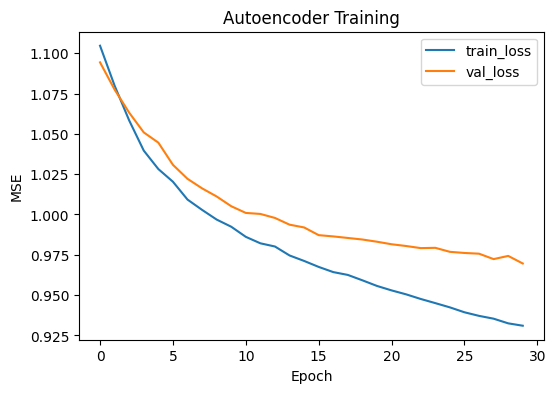

[AE] Threshold p95: 1.482489
[AE] Warning: meta (1755) != errors (183). Aligning to min length.
Saved: /content/guardian_lstm_autoencoder.keras /content/scaler.npy /content/guardian_ae_predictions.csv
Notebook ready: trains classifier if labels exist; otherwise trains AE fallback.


In [27]:
# SUPERVISED: LSTM Classifier (if labels exist)
if has_labels:
    # Drop sequences with unknown labels first (built earlier when constructing y)
    unique_labels = pd.Series(y).dropna().unique().tolist()
    if len(unique_labels) < 2:
        print("Only one (or zero) label present after windowing -> switching to Autoencoder path.")
        has_labels = False  # force AE path below

if has_labels:
    # Determine final label set and index mapping
    # Keep canonical order but only include present classes
    canonical = ["low", "medium", "high"]
    present = [c for c in canonical if c in unique_labels]
    cls_to_idx = {c: i for i, c in enumerate(present)}

    # Filter to present classes only
    keep = np.array([lbl in cls_to_idx for lbl in y])
    X = X[keep]
    y = y[keep]
    filtered_all_meta = [all_meta[i] for i, v in enumerate(keep) if v]
    y_idx = np.array([cls_to_idx[lbl] for lbl in y], dtype=np.int64)

    timesteps, n_features = X.shape[1], X.shape[2]

    # Choose head: binary vs softmax
    num_classes = len(present)
    binary_mode = (num_classes == 2)

    # Safe split: only stratify when >1 class and class counts okay
    try:
        X_train, X_val, y_train, y_val = train_test_split(
            X, y_idx, test_size=VAL_SPLIT, random_state=42, stratify=y_idx
        )
    except Exception as e:
        print("Stratified split failed (often due to tiny class counts). Falling back to non-stratified split.", e)
        X_train, X_val, y_train, y_val = train_test_split(
            X, y_idx, test_size=VAL_SPLIT, random_state=42, shuffle=True
        )

    # Model
    inputs = keras.Input(shape=(timesteps, n_features))
    x = layers.Masking()(inputs)
    x = layers.LSTM(128, return_sequences=True, dropout=0.2)(x)
    x = layers.LSTM(64, return_sequences=False, dropout=0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    if binary_mode:
        outputs = layers.Dense(1, activation="sigmoid")(x)
        loss_fn = "binary_crossentropy"
        metrics = ["accuracy"]
    else:
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        loss_fn = "sparse_categorical_crossentropy"
        metrics = ["accuracy"]

    clf = keras.Model(inputs, outputs)
    clf.compile(optimizer=keras.optimizers.Adam(LR), loss=loss_fn, metrics=metrics)
    clf.summary()

    cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)]
    hist = clf.fit(X_train, y_train, validation_data=(X_val, y_val),
                   epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=cb, verbose=1)

    # Plots
    plt.figure(figsize=(6,4))
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Classifier Training"); plt.legend(); plt.show()

    # Evaluation
    if binary_mode:
        y_prob = clf.predict(X_val, batch_size=256, verbose=0).ravel()
        y_pred_val = (y_prob >= 0.5).astype(int)
        target_names = [present[i] for i in sorted(range(num_classes))]
    else:
        y_pred_val = np.argmax(clf.predict(X_val, batch_size=256, verbose=0), axis=1)
        target_names = [present[i] for i in sorted(np.unique(y_val))]

    from sklearn.metrics import classification_report, confusion_matrix
    print(classification_report(y_val, y_pred_val, target_names=target_names))
    print("Confusion matrix:\n", confusion_matrix(y_val, y_pred_val))

    # Save model + scaler
    MODEL_PATH = f"{SAVE_DIR}/guardian_lstm_classifier.keras"
    SCALER_PATH = f"{SAVE_DIR}/scaler.npy"
    np.save(SCALER_PATH, {"mean_": scaler.mean_, "scale_": scaler.scale_, "feature_names": FEATURE_COLS}, allow_pickle=True)
    clf.save(MODEL_PATH)
    print("Saved:", MODEL_PATH, "and", SCALER_PATH)

    # Predictions for ALL sequences (filtered)
    if binary_mode:
        y_prob_all = clf.predict(X, batch_size=256, verbose=0).ravel()
        y_pred_all = (y_prob_all >= 0.5).astype(int)
        inv_idx = {i: c for c, i in cls_to_idx.items()}
        risk_pred = [inv_idx[i] for i in y_pred_all]
    else:
        y_pred_all = np.argmax(clf.predict(X, batch_size=256, verbose=0), axis=1)
        inv_idx = {i: c for c, i in cls_to_idx.items()}
        risk_pred = [inv_idx[i] for i in y_pred_all]

    res = pd.DataFrame({
        "patientId_seqEnd": [m[0] for m in filtered_all_meta],
        "seq_start_idx": [m[1] for m in filtered_all_meta],
        "seq_end_idx":   [m[2] for m in filtered_all_meta],
        "seq_end_time":  [m[3] for m in filtered_all_meta],
        "risk_pred": risk_pred
    })
    res["risk_true"] = [inv_idx[i] for i in y_idx]
    OUT_PATH = f"{SAVE_DIR}/guardian_classifier_predictions.csv"
    res.to_csv(OUT_PATH, index=False)
    print("Saved predictions:", OUT_PATH)


# =========================
# UNSUPERVISED: LSTM Autoencoder (fallback)
# =========================
else:
    # Debug: check sequence/meta sizes before split
    print(f"[AE] Total sequences: {len(X)} | meta entries: {len(all_meta)}")

    X_train, X_val = train_test_split(X, test_size=VAL_SPLIT, random_state=42, shuffle=True)
    timesteps, n_features = X.shape[1], X.shape[2]

    inputs = keras.Input(shape=(timesteps, n_features))
    # Encoder
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.LSTM(64, return_sequences=False)(x)
    encoded = layers.Dense(32, activation="relu")(x)
    # Decoder
    x = layers.RepeatVector(timesteps)(encoded)
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    outputs = layers.TimeDistributed(layers.Dense(n_features))(x)

    ae = keras.Model(inputs, outputs)
    ae.compile(optimizer=keras.optimizers.Adam(LR), loss="mse")
    ae.summary()

    cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)]
    hist = ae.fit(X_train, X_train, validation_data=(X_val, X_val),
                  epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=cb, verbose=1)

    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("Autoencoder Training"); plt.legend(); plt.show()

    # Errors
    def recon_err(m, Xb):
        Xh = m.predict(Xb, batch_size=256, verbose=0)
        return np.mean((Xh - Xb)**2, axis=(1,2))

    train_err = recon_err(ae, X_train)
    thr = np.percentile(train_err, ANOMALY_PERCENTILE)
    print(f"[AE] Threshold p{ANOMALY_PERCENTILE}: {thr:.6f}")

    all_err = recon_err(ae, X)
    is_anom = (all_err >= thr).astype(int)

    def err_to_risk(e, t):
        if e < t: return "low"
        elif e < 1.5*t: return "medium"
        else: return "high"

    risk = [err_to_risk(e, thr) for e in all_err]

    # --- Align meta and error arrays if lengths differ (common after partial re-runs)
    len_meta = len(all_meta)
    len_err  = len(all_err)
    if len_meta != len_err:
        print(f"[AE] Warning: meta ({len_meta}) != errors ({len_err}). Aligning to min length.")
        k = min(len_meta, len_err)
        all_meta = all_meta[:k]
        all_err  = all_err[:k]
        is_anom  = is_anom[:k]
        risk     = risk[:k]

    # Build results
    res = pd.DataFrame({
        "patientId_seqEnd": [m[0] for m in all_meta],
        "seq_start_idx":    [m[1] for m in all_meta],
        "seq_end_idx":      [m[2] for m in all_meta],
        "seq_end_time":     [m[3] for m in all_meta],
        "recon_error":      all_err,
        "is_anomaly":       is_anom,
        "risk_pred":        risk
    })

    # Save artifacts
    MODEL_PATH = f"{SAVE_DIR}/guardian_lstm_autoencoder.keras"
    SCALER_PATH = f"{SAVE_DIR}/scaler.npy"
    np.save(SCALER_PATH, {"mean_": scaler.mean_, "scale_": scaler.scale_, "feature_names": FEATURE_COLS}, allow_pickle=True)
    ae.save(MODEL_PATH)

    OUT_PATH = f"{SAVE_DIR}/guardian_ae_predictions.csv"
    res.to_csv(OUT_PATH, index=False)
    print("Saved:", MODEL_PATH, SCALER_PATH, OUT_PATH)

# =========================
# Inference helper (later for API)
# =========================
def make_sequence_from_rows(rows_df, scaler_obj=None, feature_cols=FEATURE_COLS, seq_len=SEQ_LEN):
    tmp = rows_df.copy()
    # parse again
    tmp["_hr"]      = tmp["heartRate"].apply(parse_heart_rate)
    tmp["_spo2"]    = tmp["spo2"].apply(parse_spo2)
    tmp["_temp"]    = tmp["temperature"].apply(parse_temperature)
    bp = tmp["bloodPressure"].apply(parse_bp)
    tmp["_bp_sys"]  = [b[0] for b in bp]
    tmp["_bp_dia"]  = [b[1] for b in bp]
    tmp["_steps"]   = tmp["stepsTaken"].apply(parse_num) if "stepsTaken" in tmp.columns else np.nan
    tmp["_cal"]     = tmp["calorieIntake"].apply(parse_num) if "calorieIntake" in tmp.columns else np.nan
    tmp["_sleep"]   = tmp["sleepHours"].apply(parse_num) if "sleepHours" in tmp.columns else np.nan
    tmp["_water"]   = tmp["waterIntakeMl"].apply(parse_num) if "waterIntakeMl" in tmp.columns else np.nan
    tmp["_exercise"]= tmp["exerciseMinutes"].apply(parse_num) if "exerciseMinutes" in tmp.columns else np.nan
    tmp["_bathroom"]= tmp["bathroomVisits"].apply(parse_num) if "bathroomVisits" in tmp.columns else np.nan
    tmp["_meals"]   = tmp["mealsSkipped"].apply(parse_num) if "mealsSkipped" in tmp.columns else np.nan

    tmp = tmp.sort_values(TIME_START_COL)
    feats = tmp[feature_cols].ffill().bfill()
    feats = feats.fillna(feats.median())

    if scaler_obj is not None:
        # scaler_obj should be dict with mean_ and scale_
        mean_ = np.array(scaler_obj.item().get("mean_")) if hasattr(scaler_obj, "item") else scaler_obj["mean_"]
        scale_= np.array(scaler_obj.item().get("scale_")) if hasattr(scaler_obj, "item") else scaler_obj["scale_"]
        feats = (feats.values - mean_) / scale_
    else:
        # If scaler_obj is None, return the raw (filled) features
        feats = feats.values

    if len(feats) != seq_len:
        raise ValueError(f"Need exactly {seq_len} rows to form one sequence, got {len(feats)}.")
    return np.expand_dims(feats.astype(np.float32), axis=0)

print("Notebook ready: trains classifier if labels exist; otherwise trains AE fallback.")